# Traffic Sign Recognition Classifier

### Prerequists

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import tensorflow as tf
import pandas as pd
from PIL import Image
from IPython.display import display, HTML

%matplotlib inline

---
## Load The Data

To download and load the data I made two small functions and added them to my datasets.py module: https://github.com/glazari/datasets. The idea behind this repo is that Deep Learning has many recurring datasets and they all have different methods for downloading and extracting the files, so this repo provides a common API to access them. (Its still under development)

In [2]:
import datasets

train_set, val_set, test_set = datasets.load_Traffic_Sings()

train_x, train_y = train_set
val_x, val_y = val_set
test_x, test_y = test_set

---

## Dataset Summary & Exploration


Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43

Sample Images


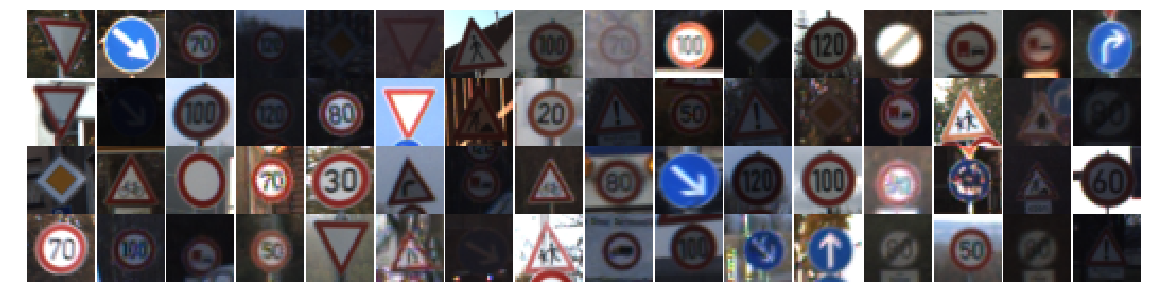

In [6]:
#dataset specs
n_train = len(train_x)
n_validation = len(val_x)
n_test = len(test_x)
image_shape = train_x[0].shape
n_classes = len(set(train_y))
print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


#view sample images
def view_samples(Imgs, title='Sample Images', size=64):
    print('\n'+title)
    n = len(Imgs)
    sample_i = np.random.choice(n, 64)
    samples = Imgs[sample_i]

    n = len(samples)

    plt.figure(figsize=(20,5))
    for i in range(n):
        plt.subplot(4,16,i+1)
        plt.imshow(samples[i])
        plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    title = title.replace(' ', '_')
    plt.savefig(title+'.png')
    plt.show()

view_samples(train_x, title='Sample Images', size=64)

The images above give us a sense of how big (or actualy small) these images are. They also give us a sense of how difficult some of these images are to classify.

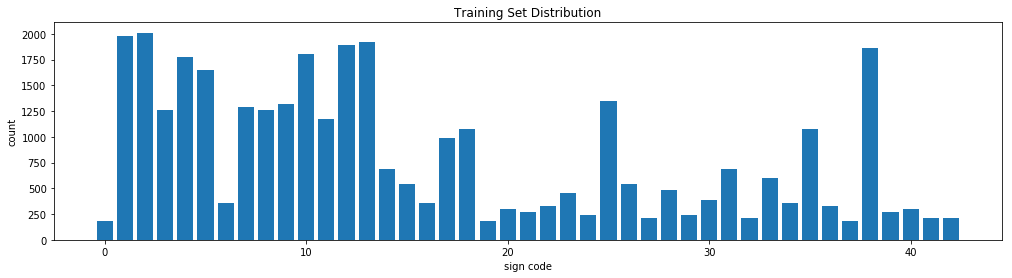

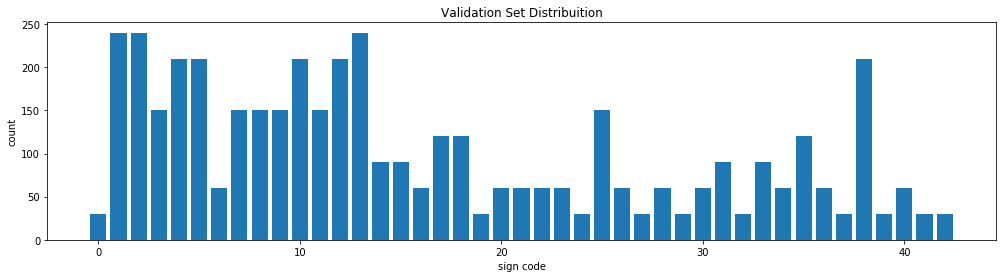

In [11]:
#Histogram of classes distribution
def hist_classes(labels, name=''):
    unique, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(17,4))
    plt.bar(unique, counts)
    plt.title(name)
    plt.xlabel('sign code')
    plt.ylabel('count')
    name = name.replace(' ', '_')
    plt.savefig(name+'_classes_histogram.png')
    plt.show()
hist_classes(train_y, 'Training Set Distribution')
hist_classes(val_y, 'Validation Set Distribuition')

The histograms above show us the frequency of occurrence of each sign code in this dataset. It is instantly obvious that some classes are more common than others. If this was too skewed, if for example a class represented 80% of the cases, then we would have to try to balance out the classes. In our case the difference is not so alarming. But one precaution that is still necessary is to check that the training data has about the same distribution as the real world. We don't have access to the real world and checking things on the test set is just cheating, so we take a look at the distribution of the validation set. The histograms above show that the distributions are very similar, so we need not worry about this.

----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set

It is common to preprocess the datasets to make things a bit easier for the model. For example, if you want your model to be rotation insensitive, train it with random rotations. If you want it to be insensitive to color, you grayscale the image. Normalizing the image gives the information of which pixels are above the average and which are below the average without it having to be learned. For this model I used Normalization and rotation. I tried to use grayscale, but it did not seem to help. Also, color seems to be important in the task of classifying signs.

1. Normalize
2. Grayscale (Discarded)
3. Rotation

Obs: grayscaling of an image is basically a 1x1 convolution with predefined weights. So a similar operation could be learned by the model.


Sample Pre-Processed Images


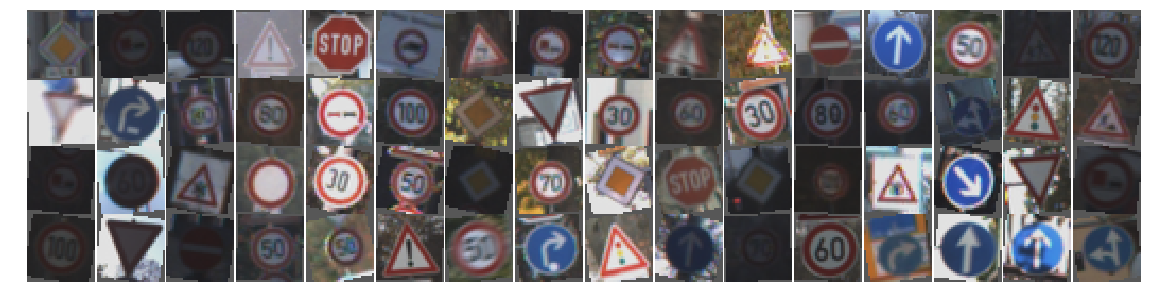

In [7]:
#processing functions
set_mean  = np.mean(train_x)
set_sigma = np.std(train_x)

def normalize(Xs):
    #normalize by training data mean and sigma
    Xs = (Xs - set_mean)/set_sigma
    return Xs

def unormalize(Xs):
    Xs = Xs*set_sigma + set_mean
    Xs = Xs/255
    Xs = Xs - np.min(Xs)
    Xs = Xs/np.max(Xs)
    return Xs

def random_rotate(images, degrees=15):
    n = len(images)
    for i in range(n):
        d = np.random.uniform(-degrees,degrees)
        images[i] = ndimage.rotate(images[i], d, reshape=False)
    return images

def rgb2gray(images):
    n = len(images)
    grays=[]
    for image in images:
        r, g, b = image[:,:,0], image[:,:,1], image[:,:,2]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
        grays.append(gray)
    
    grays = np.array(grays)
    grays = np.reshape(grays, (n,32,32,1))
    return grays

def pre_process(Xs,Ys):
    Xs = normalize(Xs)
    #Xs = rgb2gray(Xs)
    rotate1 = random_rotate(Xs, degrees=15)
    
    Xs = np.concatenate((Xs,rotate1),axis=0)
    Ys = np.concatenate((Ys,Ys),axis=0)
    return Xs, Ys

def pre_process_val(Xs,Ys):
    Xs = normalize(Xs)
    #Xs = rgb2gray(Xs)
    return Xs, Ys

#pre processing each of the datasets
train_im, train_label = pre_process(train_x, train_y)
val_im, val_label = pre_process_val(val_x, val_y)
test_im, test_label = pre_process_val(test_x, test_y)

image_shape = train_im[0].shape

#view sample processed images
ims = unormalize(train_im)
view_samples(ims, title='Sample Pre-Processed Images', size=64)

### Model Architecture

For every layer you want to add to your model you need to perform a few task. Like creating and initializing weights, setting input size and output size, adding l2_loss for those weights. The following functions abstract some of these tasks so that we can create the model with less confusion.

In [6]:
#Functions to abstract the creation of layers
sigmoid = tf.nn.sigmoid
relu = tf.nn.relu
elu = tf.nn.elu

def bias(size, zero=False):
    if zero:
        return tf.Variable(tf.zeros([size], dtype=tf.float32))
    else:
        return tf.Variable(tf.random_normal([size], stddev=0.1))

def conv(tensor, n_out, ksize=3, stride=1):
    in_shape = tensor.shape.as_list()
    n_in = in_shape[-1]
    kernels = tf.Variable(tf.random_normal([ksize, ksize, n_in, n_out],  stddev=0.1))
    loss = tf.nn.l2_loss(kernels)
    tf.add_to_collection('l2_losses', loss)
    return tf.nn.conv2d(tensor,kernels, strides=[1, stride, stride, 1], padding='SAME') + bias(n_out)

def dense(tensor, n_out):
    in_shape = tensor.shape.as_list()
    n_in = in_shape[-1]
    weights = tf.Variable(tf.random_normal(shape=(n_in, n_out), mean=0, stddev=0.1))
    loss = tf.nn.l2_loss(weights)
    tf.add_to_collection('l2_losses', loss)
    return tf.matmul(tensor, weights) + bias(n_out)

def max_pool(tensor, ksize=3, stride=1):
    return tf.nn.max_pool(tensor, ksize=[1,ksize,ksize,1], strides=[1,stride,stride,1], padding='SAME')

def flatten(tensor):
    dim = tensor.shape.as_list()
    size = np.product(dim[1:])
    print(size)
    flat = tf.reshape(tensor, [-1, size])
    return flat

Below is the actual model architecture.

In [7]:
#Model specs
n1 = 64
n2 = 64
n3 = 384
n4 = 192

#Model
x = tf.placeholder(tf.float32, [None, 32, 32, 3],'X')
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

#Layer1 convolutional
conv1 = elu(conv(x,n_out=n1, ksize=5, stride=1))
print(conv1.shape.as_list())
conv1 = max_pool(conv1,ksize=3,stride=2)
print(conv1.shape.as_list())
#Layer2 convolutional
conv2 = elu(conv(conv1,n_out=n2, ksize=5, stride=1))
print(conv2.shape.as_list())
conv2 = max_pool(conv2,ksize=3,stride=2)
print(conv2.shape.as_list())

flat = flatten(conv2)
print(flat.shape.as_list())

#Layer3 dense
dense1 = elu(dense(flat, n_out=n3))
print(dense1.shape.as_list())

#Layer4 dense
dense2 = elu(dense(dense1, n_out=n4))
print(dense2.shape.as_list())

#output
logits = dense(dense2, n_out=n_classes)
print(logits.shape.as_list())

[None, 32, 32, 64]
[None, 16, 16, 64]
[None, 16, 16, 64]
[None, 8, 8, 64]
4096
[None, 4096]
[None, 384]
[None, 192]
[None, 43]


And below here is the model loss function and accuracy operation.

In [8]:
#loss function
l_rate = 0.001

#L2 loss and 'C' coeficient to control regularization
l2_loss = tf.reduce_sum(tf.get_collection('l2_losses'))
C = tf.Variable(tf.constant(0.00002),trainable=False)
C_ph = tf.placeholder(tf.float32)
C_assign = tf.assign(C, C_ph)

#Using cross entropy loss
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

#joining l2_loss with cross entropy
loss_operation = tf.reduce_mean(cross_entropy) + C*l2_loss

#Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = l_rate)
train_step = optimizer.minimize(loss_operation)

#Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

init = tf.global_variables_initializer()
saver = tf.train.Saver()

### Train, Validate and Test the Model

Here we will train our model on the training set, evaluate it on our validation set. Make some improvements and repeat the process. Only after all tweaking is finished do we test our results on the test set.

In [9]:
sess = tf.Session()

The functions below help us abstract the training and evaluation process

In [10]:
#run epoch
def run_epoch(xs, ys, train=True, batch_size=128):
    avg_loss = 0.
    avg_acc = 0.
    for batch_xs, batch_ys in datasets.batches(xs, ys, batch_size=batch_size):
        feed_dict = {x: batch_xs, y: batch_ys}
        if train:
            opt, loss, acc = sess.run((train_step,loss_operation,accuracy_operation),
                                     feed_dict=feed_dict)
        else:
            loss, acc = sess.run((loss_operation, accuracy_operation),
                                feed_dict=feed_dict)
        n = len(xs)
        n_batch = len(batch_xs)
        avg_loss += loss / n * n_batch
        avg_acc += acc / n * n_batch
    return avg_loss, avg_acc

def set_C(val):
    sess.run(C_assign, feed_dict={C_ph:val})
    
def train(Xs, Ys, val_Xs, val_y, C_val=0.001, training_epochs=5, 
          display_step=5, batch_size=128,save=False):
    stats = "EPOCH %03d, LOSS: %.5f, ACC: %.5f, VAL_LOSS: %.5f, VAL_ACC: %.5f, l2: %.5f"
    sess.run(init)
    max_val_acc = 0
    set_C(C_val)
    val_losses = []
    losses = []
    val_accs = []
    accs = []
    for epoch in range(training_epochs):
        train_loss, train_acc = run_epoch(Xs, Ys)
        val_loss, val_acc = run_epoch(val_Xs, val_y, train=False)

        val_losses.append(val_loss)
        losses.append(train_loss)
        val_accs.append(val_acc)
        accs.append(train_acc)

        l2 = sess.run(l2_loss)
        if val_acc > max_val_acc and save:
            print('saving model', val_acc)
            max_val_acc = val_acc
            save_path = saver.save(sess, "./model_c2.ckpt")
        #Display every 'display_step' steps
        if epoch % display_step == 0:
            print(stats % (epoch+1, train_loss, train_acc, val_loss, val_acc, l2))
    if epoch % display_step != 0:
        print(stats % (epoch+1, train_loss, train_acc, val_loss, val_acc, l2))
    
    return losses, val_losses, accs, val_accs

Our model uses l2_loss. That is to say that besides the loss on the prediction error we also ad a loss that is proportional to the square of the magnitude of the weights. This loss is meant to help regularize the model. Another way of viewing this is that we force a weight to be close to zero unless it has high significance. The problem with add this loss is that you have to decide upon a proportion between the prediction loss and the regularization loss.
For this we test different proportions and then choose the best.

In [12]:
#find best C
max_C = None
max_val_acc = 0
Cs = np.logspace(-10.0, -13, 10, base = 2, dtype = np.float32)
for C_val in Cs:
    print('####### C %.7f #######' % C_val)
    results = train(train_im, train_label, val_im, val_label, 
                    C_val=C_val, training_epochs=20, display_step=5, batch_size=128)
    losses, val_losses, accs, val_accs = results
    
    if max(val_accs) > max_val_acc:
        max_val_acc = max(val_accs)
        max_C = C_val
    print('Max val acc %.5f', max(val_accs))

print('\nMax val acc ', max_val_acc, 'C', max_C)

####### C 0.0009766 #######
EPOCH 001, LOSS: 8.77866, ACC: 0.74126, VAL_LOSS: 7.22408, VAL_ACC: 0.76440, l2: 6411.66943
EPOCH 006, LOSS: 0.84157, ACC: 0.99036, VAL_LOSS: 0.98934, VAL_ACC: 0.91565, l2: 650.06677
EPOCH 011, LOSS: 0.24256, ACC: 0.99115, VAL_LOSS: 0.43838, VAL_ACC: 0.94263, l2: 183.19106
EPOCH 016, LOSS: 0.18365, ACC: 0.99109, VAL_LOSS: 0.29975, VAL_ACC: 0.95850, l2: 144.38750
EPOCH 020, LOSS: 0.15947, ACC: 0.99060, VAL_LOSS: 0.35137, VAL_ACC: 0.94739, l2: 159.04224
Max val acc %.5f 0.970068026184
####### C 0.0007751 #######
EPOCH 001, LOSS: 7.56830, ACC: 0.72850, VAL_LOSS: 6.27515, VAL_ACC: 0.77438, l2: 6930.12061
EPOCH 006, LOSS: 1.09573, ACC: 0.98737, VAL_LOSS: 1.20694, VAL_ACC: 0.92336, l2: 1123.26489
EPOCH 011, LOSS: 0.23885, ACC: 0.99244, VAL_LOSS: 0.57943, VAL_ACC: 0.90907, l2: 262.34534
EPOCH 016, LOSS: 0.15915, ACC: 0.99295, VAL_LOSS: 0.35523, VAL_ACC: 0.95102, l2: 156.48351
EPOCH 020, LOSS: 0.14752, ACC: 0.99083, VAL_LOSS: 0.58027, VAL_ACC: 0.93197, l2: 207.50177

Once chosen the best proportion C, we train for a longer time and se what happens.

saving model 0.794331065841
EPOCH 001, LOSS: 3.83466, ACC: 0.75315, VAL_LOSS: 3.29333, VAL_ACC: 0.79433, l2: 7800.89844
saving model 0.836507936373
saving model 0.84557823059
saving model 0.894784580337
saving model 0.914739228565
EPOCH 006, LOSS: 0.94847, ACC: 0.99072, VAL_LOSS: 1.29645, VAL_ACC: 0.91474, l2: 2611.12866
saving model 0.940589569215
EPOCH 011, LOSS: 0.30404, ACC: 0.98953, VAL_LOSS: 0.60565, VAL_ACC: 0.93787, l2: 810.11548
saving model 0.946258502888
saving model 0.951700679786
saving model 0.958049886405
EPOCH 016, LOSS: 0.17146, ACC: 0.99141, VAL_LOSS: 0.39484, VAL_ACC: 0.95193, l2: 472.13824
saving model 0.975056688829
EPOCH 021, LOSS: 0.06720, ACC: 0.99891, VAL_LOSS: 0.34753, VAL_ACC: 0.92313, l2: 220.93155
EPOCH 026, LOSS: 0.12370, ACC: 0.99511, VAL_LOSS: 0.24130, VAL_ACC: 0.96803, l2: 299.18073
EPOCH 031, LOSS: 0.06291, ACC: 0.99991, VAL_LOSS: 0.22583, VAL_ACC: 0.97166, l2: 173.13416
EPOCH 036, LOSS: 0.12738, ACC: 0.98782, VAL_LOSS: 0.35519, VAL_ACC: 0.95488, l2: 3

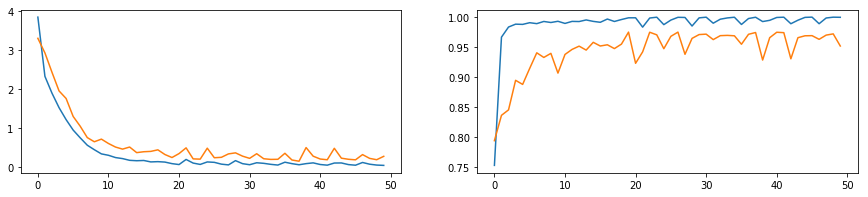

CPU times: user 5min 31s, sys: 1min 36s, total: 7min 7s
Wall time: 8min 27s


In [13]:
%%time
#train with chosen C for more epochs
results = train(train_im, train_label, val_im, val_label, 
                    C_val=0.000307598, training_epochs=50, display_step=5, batch_size=128, save=True)

losses, val_losses, accs, val_accs = results

print('Max val acc %.5f', max(val_accs))

plt.figure(figsize=(15,3))
plt.subplot(121)
plt.plot(losses)
plt.plot(val_losses)
plt.subplot(122)
plt.plot(accs)
_ = plt.plot(val_accs)
plt.show()

In [15]:
#test
test_loss, test_acc = run_epoch(test_im, test_label, train=False, batch_size=128)
print(test_acc)

0.947505938167


### l2 loss
ls loss is the square of the norm of the weights. In other words it is a measure of how big the weights are. At first sight it may not be evident why penalizing large weights could be helpful, if anything, it seems like it would be bad, as it penalises something that is not directly related to the accuracy. But l2 loss have been empirically shown to be a good regularization method. And there are theoretical justifications as well.
 
    total_loss = loss + C*l2_loss

Lets try to take an intuitive look at it. Let's imagine that there is no penalization for the weight size. Since the model starts out at random then there is a chance that in the beginning an irrelevant feature has a high weight. The model has two ways to correct this, either it lowers the weights of the irrelevant feature, which is what we want. Or it does the unintuitive thing of raising another irrelevant feature's weight in the opposite direction so that they cancel each other out. Although they both work they are not equally good options. The l2 loss tells the model that lowering the size of the wiehgts is better than "compensating" with other weights. This also helps generalization as irrelevant features end up being ignored quicker.

With that said, there is still the question of how much should you penalize the weights. Penalize too much and you get a model with zero weights and no acc, too little and you might as well not have the penalization. To choose just how much we try out different Cs and check the validation acc we can achieve.

Note: since the loss for different Cs will have different weights for the l2_loss, it is no longer reliable to compare loss between these tests, that is why we compare acc.

Below are a few of the test for choosing C

    C = 0.001    -> 0.94
    C = 0.0004   -> 0.97
    C = 0.0003   -> 0.97
    C = 0.0002   -> 0.98
    C = 0.0001   -> 0.968
    C = 0.000075 -> 0.972
    C = 0.00005  -> 0.965
    C = 0.00001  -> 0.92

---

## Step 3: Test a Model on New Images


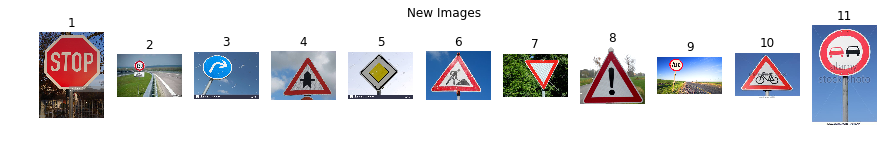

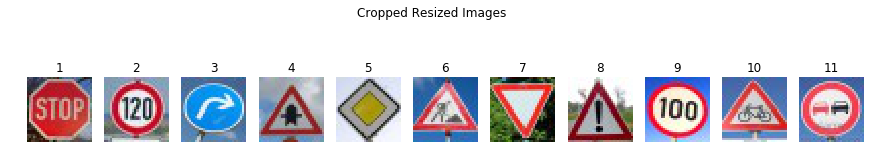

In [16]:
### Load the images and plot them here.
new_signs = os.listdir('New_Signs/')
new_signs = [im for im in new_signs if 'Cropped' not in im]
ims = []
for sign in new_signs:
    im = Image.open('New_Signs/'+sign)
    ims.append(np.array(im.getdata()).reshape(im.size[1], im.size[0], 3).astype('ubyte'))

plt.figure(figsize=(15,2))
plt.suptitle('New Images')
n = len(ims)
for i, im in enumerate(ims):
    plt.subplot(1,n,i+1)
    plt.imshow(im)
    plt.title(i+1)
    plt.axis('off')

### Resized and croped images
new_signs = os.listdir('New_Signs/Cropped/')
ims = []
for sign in new_signs:
    im = Image.open('New_Signs/Cropped/'+sign)
    ims.append(np.array(im.getdata()).reshape(im.size[1], im.size[0], 3).astype('ubyte'))

plt.figure(figsize=(15,3))
plt.suptitle('Cropped Resized Images')
n = len(ims)
for i, im in enumerate(ims):
    plt.subplot(1,n,i+1)
    plt.imshow(im)
    plt.title(i+1)
    plt.axis('off')

In [17]:
### Run the predictions here and use the model to output the prediction for each image.
new_images = np.array(ims)
def prediction(ims):
    log = sess.run(logits, feed_dict={x: ims})
    predictions = np.argmax(log,axis=1)
    
    sign_names = pd.DataFrame.from_csv('signnames.csv')
    names = sign_names['SignName']
    names = [names[i] for i in predictions]
    
    return  names
pred_names = prediction(ims)

correct_names = ['Stop', 'Speed limit (120km/h)', 'Turn right ahead',
                 'Right-of-way at the next intersection', 'Priority road', 'Road work',
                 'Yield', 'General caution','Speed limit (100km/h)','Bicycles crossing',
                 'No passing']

df = pd.DataFrame({'prediction':pred_names, 'correct':correct_names}, index=range(1,12))
display(df[['prediction','correct']])

print('Accuracy is 9 out of 11: %.3f'%(9/11))

/home/glazari/miniconda3/envs/auto/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  import sys


,prediction,correct
1,Stop,Stop
2,Speed limit (60km/h),Speed limit (120km/h)
3,Turn right ahead,Turn right ahead
4,Right-of-way at the next intersection,Right-of-way at the next intersection
5,Priority road,Priority road
6,Road work,Road work
7,Yield,Yield
8,General caution,General caution
9,Speed limit (60km/h),Speed limit (100km/h)
10,Bicycles crossing,Bicycles crossing


Accuracy is 9 out of 11: 0.818


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [18]:
#difine tensorflow operations
top_5 = tf.nn.top_k(logits, k=5, sorted=True)
softmax = tf.nn.softmax(logits)
softmax_top_5 = tf.nn.softmax(top_5.values)
in_top_5 = tf.nn.in_top_k(logits, y, k=5)

It just so happens that our model is so "sure" of itself that all of the probabilities are 0 except for the one that it acutaly chooses. This seems like a sign of overfitting though I have never heard of this happening. 

In [19]:
st5 = sess.run(softmax_top_5, feed_dict={x: ims})
st5

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.97714841,  0.02285165,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ]], dtype=float32)

Because of this we will look at the top 5 logits instead

In [20]:
lt5 = sess.run(top_5, feed_dict={x: ims})
values = lt5.values
classes = lt5.indices


names = sign_names['SignName']
i = 0
for i in range(len(ims)):
    v = values[i]
    c = classes[i]
    df = pd.DataFrame(columns=('Class','Score'))
    plt.figure(figsize=(2,2))
    plt.imshow(ims[i])
    plt.axis('off')
    plt.show()
    for j in range(5):
        names[c[j]]
        df.loc[j]=(names[c[j]],v[j])
    display(df)

NameError: name 'sign_names' is not defined